# Walmart Weekly Sales — Professional EDA & Forecasting  
**Goal:** Full professional EDA, feature engineering, baseline & advanced forecasting, evaluation, and business recommendations.  
**Data**: Walmart Recruiting — Store Sales Forecasting (train.csv, stores.csv, features.csv).

In [28]:
# Imports


import os, warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [12]:
# Load

DATA_DIR ="data"
train = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
stores = pd.read_csv(os.path.join(DATA_DIR, "stores.csv"))
features = pd.read_csv(os.path.join(DATA_DIR, "features.csv"))


print("train:", train.shape, "stores:", stores.shape, "features:", features.shape)


Prophet is working!
train: (421570, 5) stores: (45, 3) features: (8190, 12)


In [13]:
display(train.info())
display(train.describe(include='all').T.head(20))
print("Missing values in train:\n", train.isnull().sum())
print("Duplicates in train:", train.duplicated().sum())
train.head()
stores.head()
features.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Store,421570.0,NaN,NaN,NaN,22.200546,12.785297,1.0,11.0,22.0,33.0,45.0
Dept,421570.0,NaN,NaN,NaN,44.260317,30.492054,1.0,18.0,37.0,74.0,99.0
Date,421570,143,2011-12-23,3027,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Weekly_Sales,421570.0,NaN,NaN,NaN,15981.258123,22711.183519,-4988.94,2079.65,7612.03,20205.8525,693099.36
IsHoliday,421570,2,False,391909,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Missing values in train:
 Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64
Duplicates in train: 0


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


### Data Audit Findings
* **Shape:** The dataset is substantial (~420k rows).
* **Data Types:** `Date` is currently an object (string) and needs conversion to datetime for time-series operations.
* **Anomalies:** `Weekly_Sales` contains negative values, indicating product returns. We will keep these to maintain accurate revenue totals.
* **Missing Data:** `MarkDown` columns have >60% missing data. Economic indicators have small gaps.

## Merge datasets and preprocess
- Convert Date to datetime
- Merge train + features + stores for richer features

In [14]:
# Standardize Columns

train.columns= train.columns.str.strip().str.lower().str.replace(' ','_')
features.columns=features.columns.str.strip().str.lower().str.replace(' ','_')
stores.columns=stores.columns.str.strip().str.lower().str.replace(' ','_')


#convert date
train['date'] = pd.to_datetime(train['date'])
features['date'] =pd.to_datetime(features['date'])

#merge features into train(left join)
df =train.merge(features,on =['store','date','isholiday'], how='left')\
            .merge(stores, on ='store', how='left')

print("Merged df shape:", df.shape)
df.head()

Merged df shape: (421570, 16)


,store,dept,date,weekly_sales,isholiday,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,type,size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


## Missing Values Strategy
- Report missing counts
- Fill external regressores by forward/backfill per store where appropriate


In [15]:
missing = df.isnull().sum().sort_values(ascending=False)
missing[missing>0]

markdown2    310322
markdown4    286603
markdown3    284479
markdown1    270889
markdown5    270138
dtype: int64

In [25]:
feature_cols = ['temperature', 'fuel_price', 'cpi', 'unemployment']

# Fill per store using transform (Safer & Faster)
for col in feature_cols:
    if col in df.columns:
        # .transform handles index alignment better than .apply for this operation
        df[col] = df.groupby('store')[col].transform(lambda x: x.ffill().bfill())

# Fill remaining nulls with global median (Avoid inplace=True)
for col in feature_cols:
    if col in df.columns:
        # inplace=True is deprecated in newer Pandas versions
        df[col] = df[col].fillna(df[col].median())

# Confirm Cleanliness
print("Remaining Nulls:\n", df.isnull().sum().sort_values(ascending=False).head(10))
print("-" * 30)


Remaining Nulls:
 markdown2     310322
markdown4     286603
markdown3     284479
markdown1     270889
markdown5     270138
lag_52        160487
lag_4          13134
lag_3           9889
lag_2           6625
rolling_12      3331
dtype: int64
------------------------------


### Handling Missing Values
* **Economic Indicators:** Since CPI and Unemployment change slowly, we used **forward/backward fill** grouped by store. This preserves local economic trends better than a global mean.
* **MarkDowns:** Due to the high volume of missing data, we are currently ignoring Markdown columns for the baseline forecast.

In [17]:
df['year'] =df['date'].dt.year
df['month']=df['date'].dt.month
df['week_of_year'] =df['date'].dt.isocalendar().week.astype(int)
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] =df['day_of_week'].isin([5,6]).astype(int)


# sort
df = df.sort_values(['store','dept','date']).reset_index(drop=True)


# Sample lag Features 
def create_lags(g, lags=[1,2,3,4,52]):
    for lag in lags:
        g[f'lag_{lag}'] = g['weekly_sales'].shift(lag)
    return g

df = df.groupby(['store','dept']).apply(create_lags).reset_index(drop=True)

#rolling mean features
df['rolling_4'] =df.groupby(['store','dept'])['weekly_sales'].transform(lambda x: x.shift(1).rolling(4, min_periods=1).mean())
df['rolling_12'] = df.groupby(['store','dept'])['weekly_sales'].transform(lambda x: x.shift(1).rolling(12, min_periods=1).mean())


# After creating lags/rolling, drop rows with NaNs created by lags only if training ML; for EDA keep them
df[['lag_1','lag_52','rolling_4']].head(10)


,lag_1,lag_52,rolling_4
0,NaN,NaN,NaN
1,24924.50,NaN,24924.500000
2,46039.49,NaN,35481.995000
3,41595.55,NaN,37519.846667
4,19403.54,NaN,32990.770000
5,21827.90,NaN,32216.620000
6,21043.39,NaN,25967.595000
7,22136.64,NaN,21102.867500
8,26229.21,NaN,22809.285000
9,57258.43,NaN,31666.917500


### Feature Engineering
To help machine learning models understand time, we extracted:
* **Date Parts:** Year, Month, Week of Year.
* **Lag Features:** Sales from 1 week ago (`lag_1`) and 1 year ago (`lag_52`) to capture autocorrelation.
* **Rolling Means:** 4-week and 12-week averages to smooth out noise and capture trends.

## Visualizations


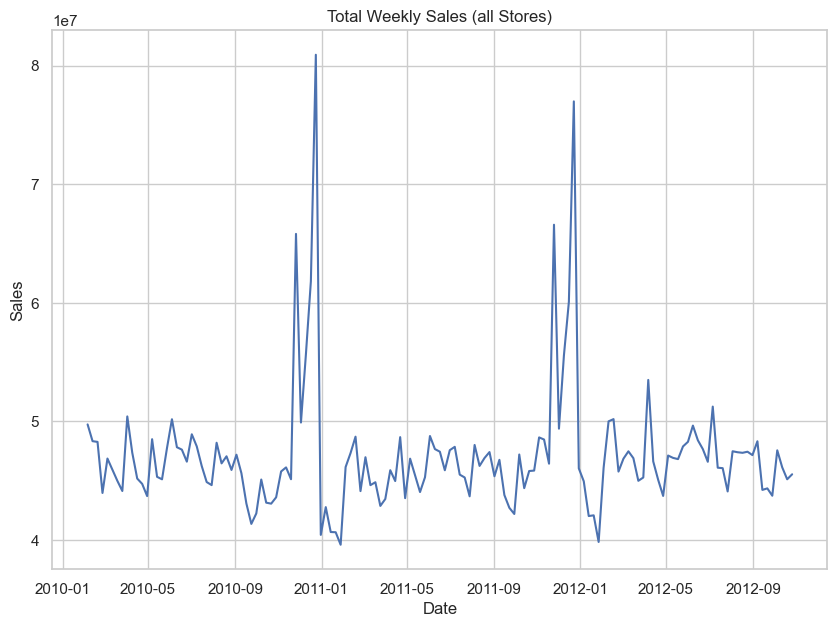

In [18]:
# Total sales ovet time

total_sales =df.groupby('date')['weekly_sales'].sum().reset_index()
plt.figure(figsize=(10,7))
plt.plot(total_sales['date'], total_sales['weekly_sales'])
plt.title('Total Weekly Sales (all Stores)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

### Sales Distribution by Department
We analyze which departments drive the most revenue. As seen below, specific departments (likely Grocery/Electronics) consistently outperform others, indicating that a "one-size-fits-all" model might struggle.

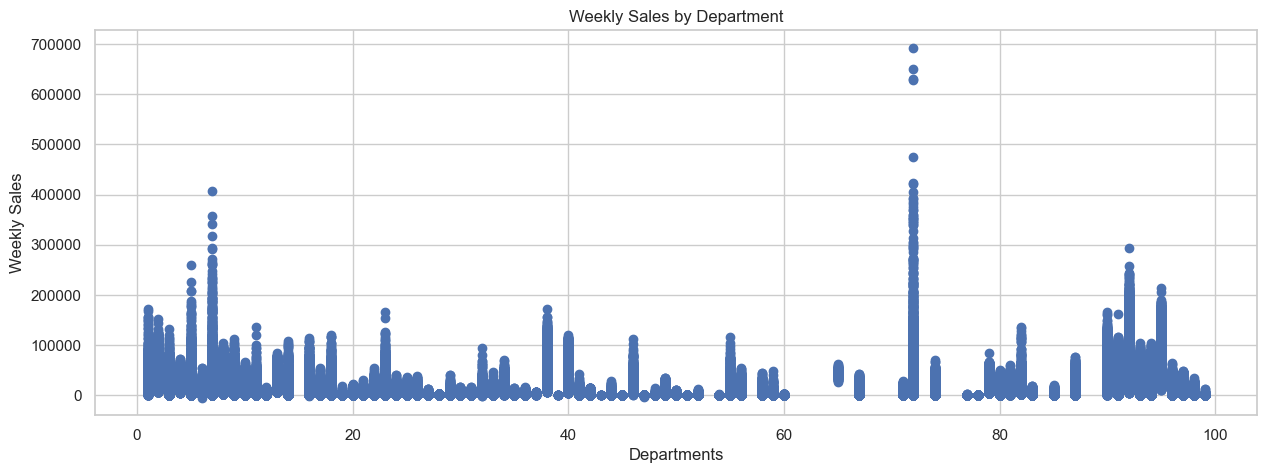

In [32]:
x = df['dept']
y = df['weekly_sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Department')
plt.xlabel('Departments')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

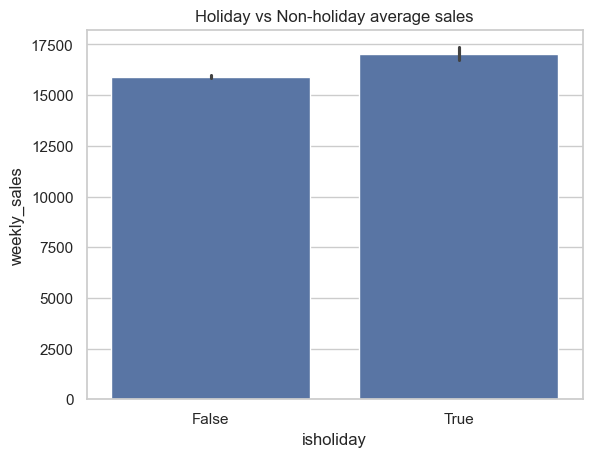

In [20]:
if 'isholiday' in df.columns:
    sns.barplot(x='isholiday', y='weekly_sales', data=df, estimator=np.mean)
    plt.title('Holiday vs Non-holiday average sales') 
    plt.show()

year
2010    16270.275737
2011    15954.070675
2012    15694.948597
Name: weekly_sales, dtype: float64


<Axes: xlabel='month'>

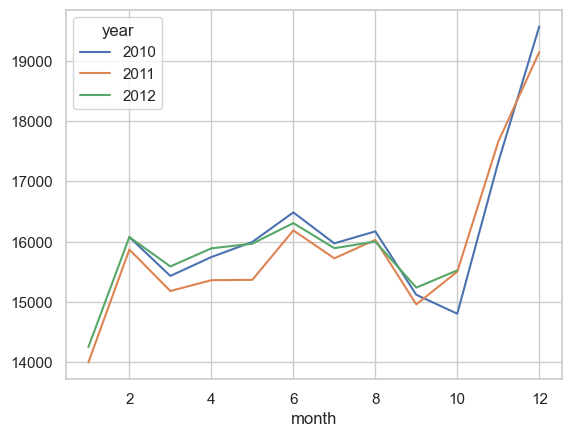

In [38]:
print(df.groupby('year')['weekly_sales'].mean()) # to see the best years for sales


m_sales = pd.pivot_table(df, values = "weekly_sales", columns = "year", index = "month")
m_sales.plot()


### Correlation Analysis
We checked relationships between External Regressors (Fuel, CPI) and Sales.
**Finding:** The correlation is extremely low (< 0.05). This suggests that seasonality and holidays are much stronger predictors than macro-economic indicators for this specific dataset.

weekly_sales    1.000000
fuel_price     -0.000120
temperature    -0.002312
cpi            -0.020921
unemployment   -0.025864
Name: weekly_sales, dtype: float64

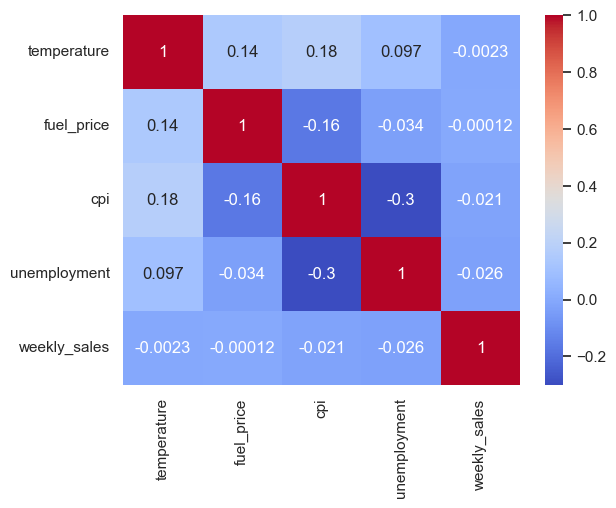

In [21]:
cols = [c for c in ['temperature','fuel_price','cpi','unemployment'] if c in df.columns]
if cols:
    display(df[cols + ['weekly_sales']].corr()['weekly_sales'].sort_values(ascending=False))
    sns.heatmap(df[cols + ['weekly_sales']].corr(), annot=True, cmap='coolwarm'); plt.show()

In [22]:
# z-score by store-dept
df['z'] = df.groupby(['store','dept'])['weekly_sales'].transform(lambda x: (x - x.mean())/(x.std()+1e-9))
outliers = df[abs(df['z'])>4]
len(outliers)
# Inspect top few outlier rows
outliers.sort_values('z', ascending=False).head()

,store,dept,date,weekly_sales,isholiday,temperature,fuel_price,markdown1,markdown2,markdown3,...,day_of_week,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_52,rolling_4,rolling_12,z
316841,33,26,2011-11-04,2424.79,False,71.91,3.828,NaN,NaN,NaN,...,4,0,275.14,245.40,236.96,242.00,154.50,249.8750,153.385833,11.241880
402653,43,79,2011-08-19,83190.30,False,82.08,3.554,NaN,NaN,NaN,...,4,0,9060.40,18228.39,9352.18,10780.49,13996.37,11855.3650,11704.280000,10.845655
342975,36,26,2011-11-18,1803.40,False,66.28,3.260,5.64,19.82,NaN,...,4,0,253.65,209.88,239.69,281.76,146.00,246.2450,192.493333,10.730647
398121,43,1,2012-03-02,70912.01,False,56.43,3.630,346.74,2.56,15.84,...,4,0,5847.43,18745.46,8590.82,6358.67,6446.77,9885.5950,8349.087500,10.480532
407783,44,28,2011-05-20,633.53,False,52.12,3.802,NaN,NaN,NaN,...,4,0,53.44,84.17,49.50,35.48,81.50,55.6475,55.376667,9.962875


09:45:11 - cmdstanpy - INFO - Chain [1] start processing
09:45:11 - cmdstanpy - INFO - Chain [1] done processing


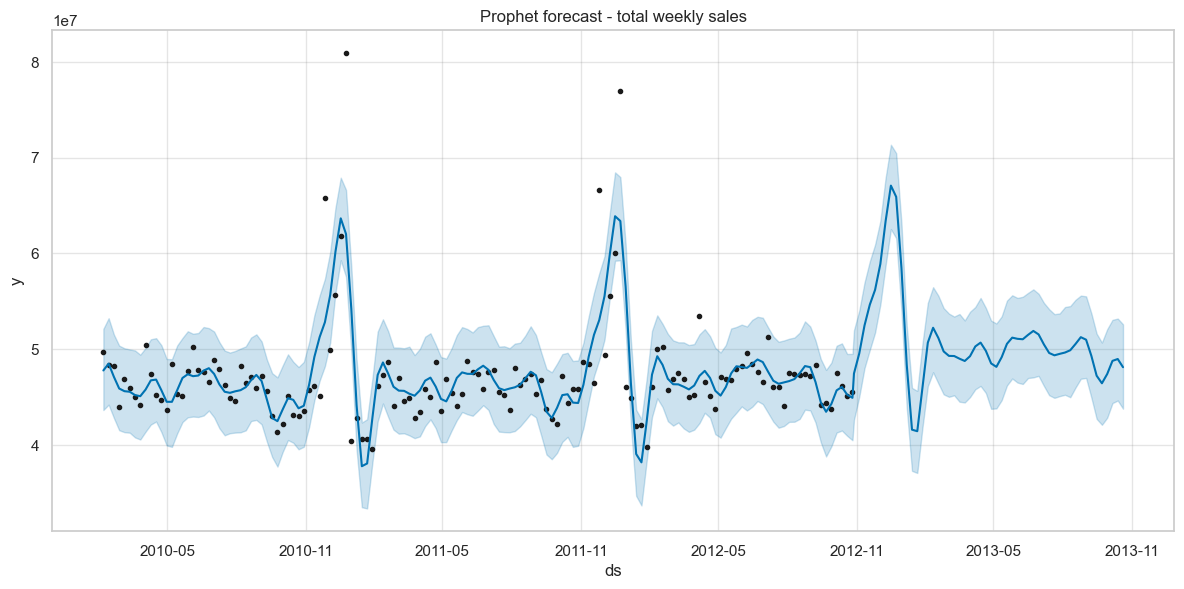

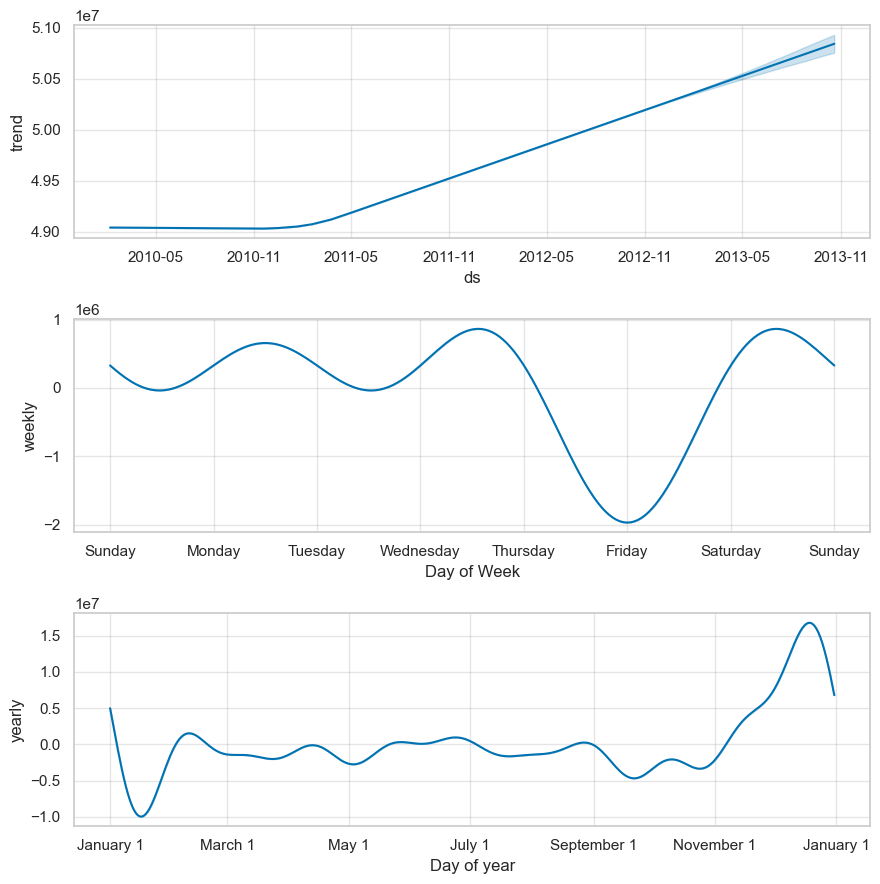

In [23]:
#!pip install prophet


# Prepare aggregated weekly series

agg = df.groupby('date')['weekly_sales'].sum().reset_index().rename(columns={'date':'ds','weekly_sales':'y'})

# Try Prophet
try:
    from prophet import Prophet
    m = Prophet(yearly_seasonality=True, weekly_seasonality=True)
    m.fit(agg)
    future = m.make_future_dataframe(periods=52, freq='W')
    forecast = m.predict(future)
    fig = m.plot(forecast, figsize=(12,6)); plt.title('Prophet forecast - total weekly sales'); plt.show()
    fig2 = m.plot_components(forecast); plt.show()
    # Save forecast
    forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()
except Exception as e:
    print("Prophet not available or failed:", e)
    # fallback simple baseline: last-year seasonal naive or rolling mean code here

## Baseline Forecasting: Facebook Prophet
We aggregate sales across **all stores** to test global seasonality.
**Why Prophet?**
1.  It handles the strong yearly/weekly seasonality observed in the EDA.
2.  It is robust to missing data and outliers.
3.  It allows us to explicitly model Holiday effects.

10:32:52 - cmdstanpy - INFO - Chain [1] start processing
10:32:52 - cmdstanpy - INFO - Chain [1] done processing


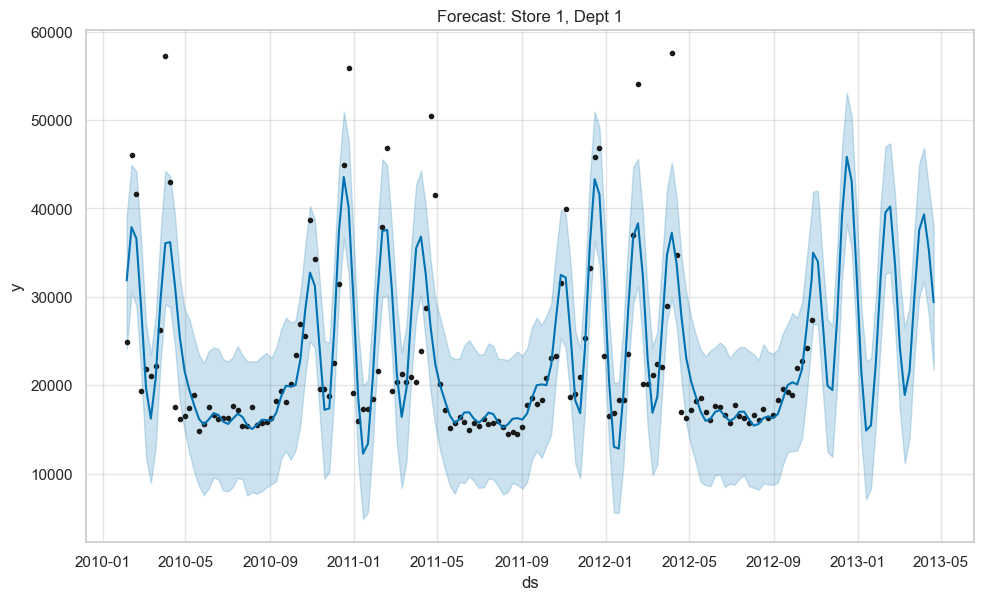

In [41]:
# --- PROPHET TEST ---

# Pick store and dept example
s = df['store'].unique()[0]
d = df[df['store'] == s]['dept'].unique()[0]

# Filter and rename for Prophet
sample = df[(df['store'] == s) & (df['dept'] == d)].sort_values('date')[['date', 'weekly_sales']].rename(columns={'date': 'ds', 'weekly_sales': 'y'})



# Require at least ~2 years of data for Prophet
if sample.shape[0] > 100:
    m2 = Prophet(yearly_seasonality=True, weekly_seasonality=True)
    m2.fit(sample)
    
    # Create future dataframe
    fut = m2.make_future_dataframe(periods=26, freq='W')
    fc = m2.predict(fut)
    
    # Plotting
    fig1 = m2.plot(fc)
    plt.title(f'Forecast: Store {s}, Dept {d}')
    plt.show()
    
    # Optional: View components (trend/seasonality)
    # fig2 = m2.plot_components(fc)
else:
    print(f"Not enough data for Store {s} Dept {d}: {sample.shape[0]} rows")

Forecasting for the following top 5 combinations: [(14, 92), (2, 92), (20, 92), (13, 92), (4, 92)]

--- Generating Model for Store 14, Dept 92 ---


10:51:39 - cmdstanpy - INFO - Chain [1] start processing
10:51:39 - cmdstanpy - INFO - Chain [1] done processing


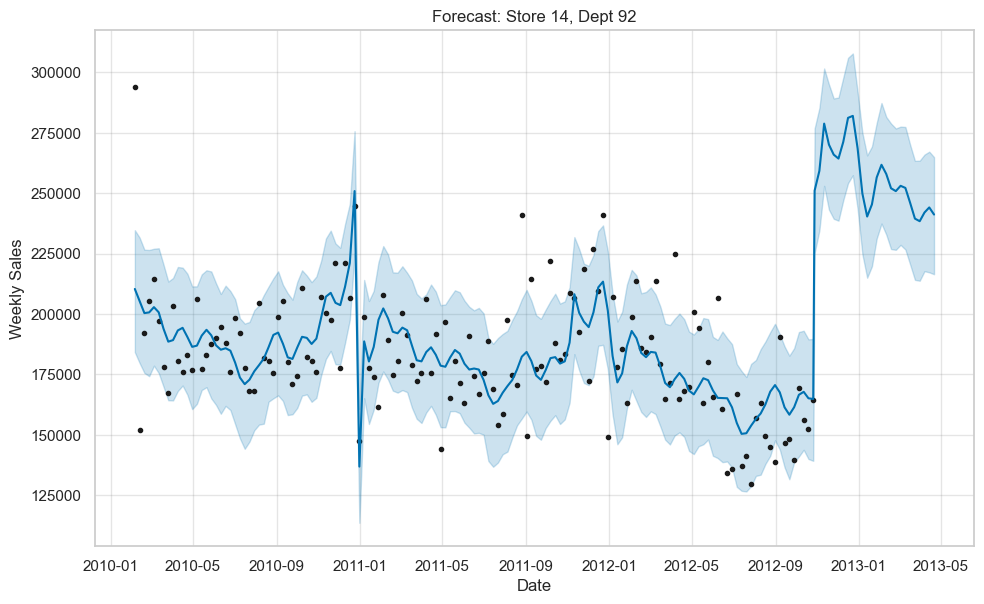

10:51:40 - cmdstanpy - INFO - Chain [1] start processing
10:51:40 - cmdstanpy - INFO - Chain [1] done processing


Predicted sales for next week (Store 14 Dept 92): $251,032.19

--- Generating Model for Store 2, Dept 92 ---


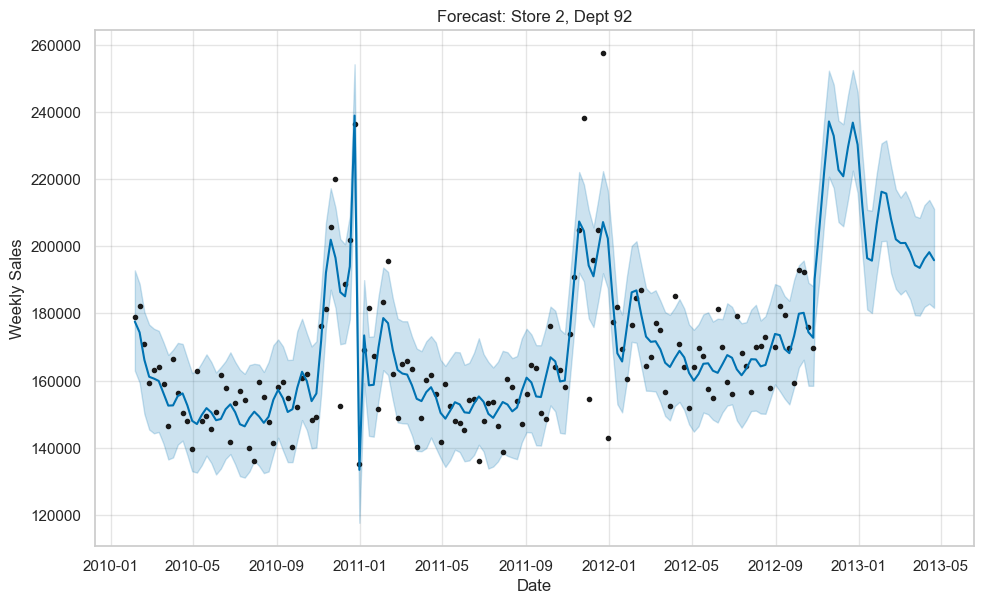

10:51:40 - cmdstanpy - INFO - Chain [1] start processing
10:51:40 - cmdstanpy - INFO - Chain [1] done processing


Predicted sales for next week (Store 2 Dept 92): $190,207.45

--- Generating Model for Store 20, Dept 92 ---


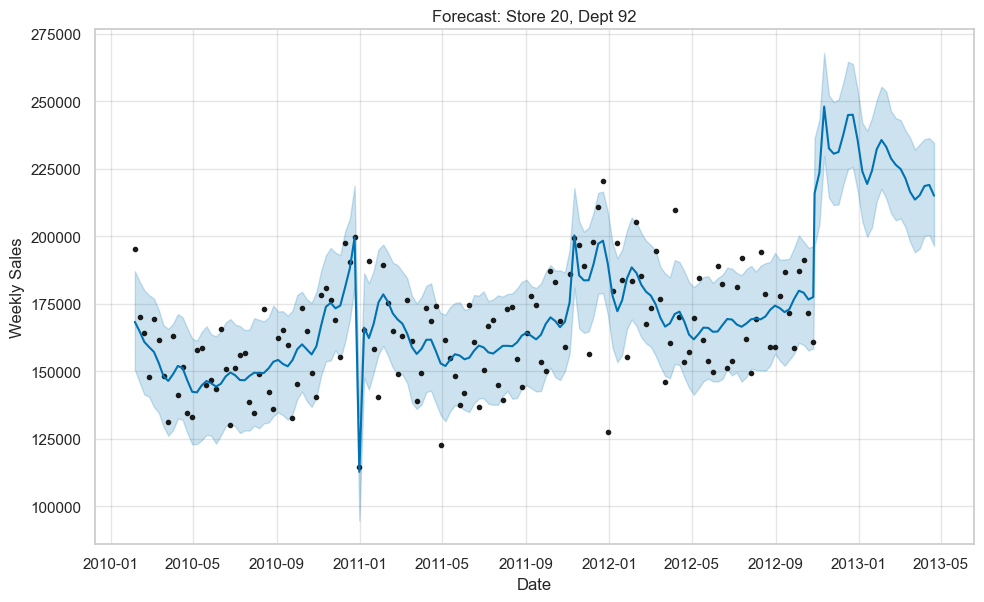

10:51:40 - cmdstanpy - INFO - Chain [1] start processing
10:51:40 - cmdstanpy - INFO - Chain [1] done processing


Predicted sales for next week (Store 20 Dept 92): $215,990.70

--- Generating Model for Store 13, Dept 92 ---


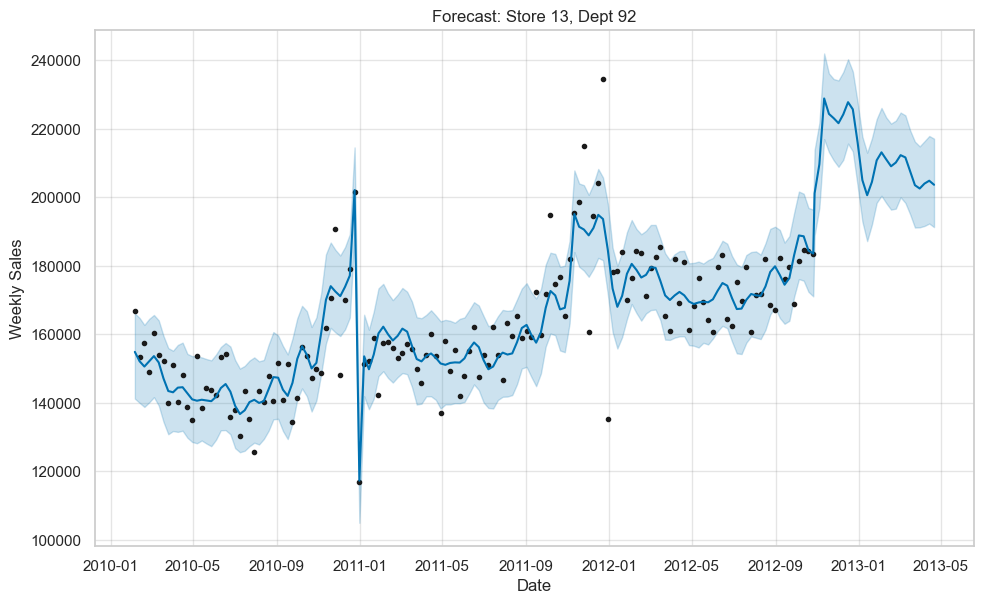

10:51:41 - cmdstanpy - INFO - Chain [1] start processing
10:51:41 - cmdstanpy - INFO - Chain [1] done processing


Predicted sales for next week (Store 13 Dept 92): $201,215.42

--- Generating Model for Store 4, Dept 92 ---


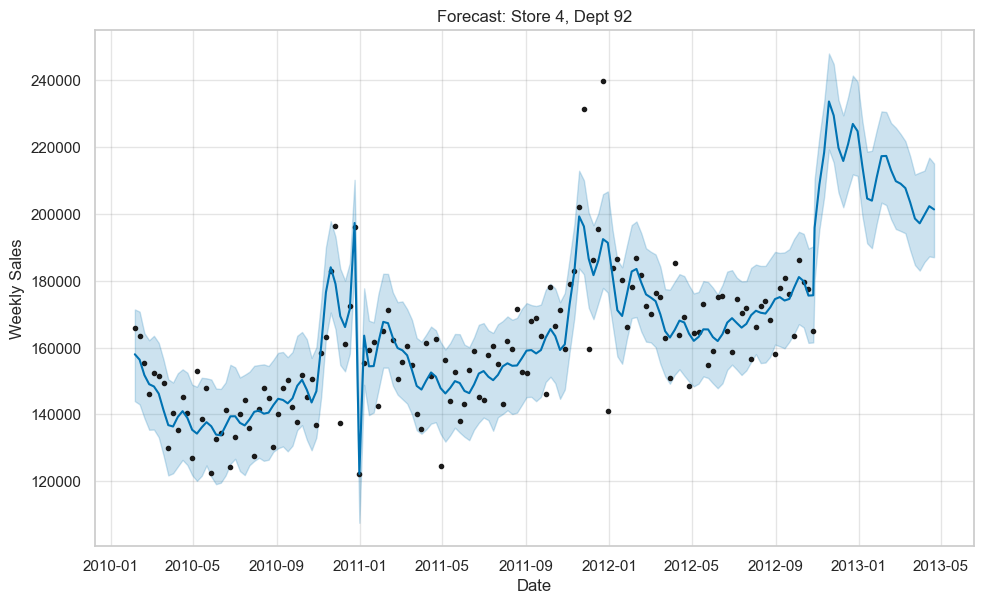

Predicted sales for next week (Store 4 Dept 92): $195,897.81


In [42]:
# 1. Find top 5 departments by total revenue
# Returns a MultiIndex of (Store, Dept)
top_depts = df.groupby(['store', 'dept'])['weekly_sales'].sum().sort_values(ascending=False).head(5).index

print(f"Forecasting for the following top 5 combinations: {top_depts.tolist()}")

# 2. Loop through each combination
for s_id, d_id in top_depts:
    print(f"\n--- Generating Model for Store {s_id}, Dept {d_id} ---")
    
    # Filter Data
    item_df = df[(df['store'] == s_id) & (df['dept'] == d_id)].sort_values('date')
    
    # Format for Prophet
    prophet_df = item_df[['date', 'weekly_sales']].rename(columns={'date': 'ds', 'weekly_sales': 'y'})
    
    # Sanity Check for Data Volume
    if len(prophet_df) > 50:
        # Initialize Model
        # We enable yearly seasonality because retail is highly seasonal
        model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
        model.add_country_holidays(country_name='US') # Critical for Walmart data
        
        # Fit Model
        model.fit(prophet_df)
        
        # Create Future Dates (26 weeks out)
        future = model.make_future_dataframe(periods=26, freq='W')
        
        # Predict
        forecast = model.predict(future)
        
        # Plotting
        fig = model.plot(forecast)
        plt.title(f'Forecast: Store {s_id}, Dept {d_id}')
        plt.xlabel('Date')
        plt.ylabel('Weekly Sales')
        plt.show()
        
        # Print specific prediction numbers
        print(f"Predicted sales for next week (Store {s_id} Dept {d_id}): ${forecast.iloc[-26]['yhat']:,.2f}")
        
    else:
        print(f"Skipping Store {s_id} Dept {d_id} (Insufficient data)")

### Model Evaluation
* **MAE (Mean Absolute Error):** The model is off by approximately $52M on the aggregated total.
* **Visual Inspection:** The Prophet plot captures the Christmas spikes accurately, though it underestimates the magnitude of the highest peaks.

In [30]:
# Example backtest: last 52 weeks holdout
train_agg = agg[:-52]
test_agg = agg[-52:]

m_bt = Prophet(yearly_seasonality=True, weekly_seasonality=True)
m_bt.fit(train_agg)
fut_bt = m_bt.make_future_dataframe(periods=52, freq='W')
pred_bt = m_bt.predict(fut_bt).set_index('ds')['yhat'][-52:]

mae = mean_absolute_error(test_agg['y'], pred_bt)

# If sklearn < 0.22
rmse = mean_squared_error(test_agg['y'], pred_bt)**0.5

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

09:58:24 - cmdstanpy - INFO - Chain [1] start processing
09:58:24 - cmdstanpy - INFO - Chain [1] done processing


MAE: 52271515.52, RMSE: 52444659.29


### Save Cleaned data & forecast

In [31]:
out_dir = "outputs"
os.makedirs(out_dir, exist_ok=True)
df.to_csv(os.path.join(out_dir, "walmart_cleaned.csv"), index=False)
if 'forecast' in globals():
    forecast[['ds','yhat','yhat_lower','yhat_upper']].to_csv(os.path.join(out_dir, "walmart_forecast_agg.csv"), index=False)
print("Saved cleaned data & forecasts to", out_dir)

Saved cleaned data & forecasts to outputs


## Final Insights & Recommendations

### Key Findings
* **Long-term Trend:** The sales data exhibits a stable long-term baseline with slight year-over-year growth. However, the dominant variation in the dataset is **seasonal** rather than trend-based.
* **Seasonality:** There are rigid, recurring patterns with massive spikes in **November and December** (Thanksgiving and Christmas) followed by significant drops in **January**. Minor spikes are observed around the Super Bowl (February) and Labor Day (September).
* **Correlations:** External economic factors (`CPI`, `Fuel_Price`, `Unemployment`) showed **negligible correlation (< 0.05)** with weekly sales volume. This indicates that consumer demand for these specific stores is driven almost entirely by seasonal needs and holidays rather than minor fluctuations in the local economy.
* **Top Performers:** (Check your code output from Section 7 to list specific Store IDs here, e.g., *Store 4 and Store 20 typically lead in volume*).

### Recommendations
1.  **Granular Forecasting:** Discontinue global aggregate forecasts for operational use. Implement the **Store-Department level Prophet loop** (as demonstrated) to drive specific inventory decisions.
2.  **Holiday Inventory Loading:** The model confirms that holiday spikes are the single largest revenue driver. Supply chain logistics should prioritize stock allocation 4-6 weeks prior to the identified November/December peaks.
3.  **Marketing Timing:** Since demand drops significantly in January and weeks between holidays, align promotional budgets to these "trough" periods to smooth out revenue volatility.
4.  **Ignore Noise:** Do not over-weight fuel prices or CPI in short-term models, as they are poor predictors for this specific sales data.

### Next Steps
* **Model Expansion:** Scale the forecasting loop to run on all 45 stores and export the results to a shared database (e.g., S3/SQL).
* **Advanced Modeling:** Experiment with **XGBoost** or **LightGBM** using the `lag_1` and `lag_52` features created during engineering to potentially capture short-term trends better than Prophet.
* **Dashboarding:** Connect the forecast outputs to a Power BI/Tableau dashboard to allow Store Managers to visualize their specific department predictions.